<a href="https://colab.research.google.com/github/jumbokh/csu1112-class/blob/main/class/vision/basic_image_adversaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

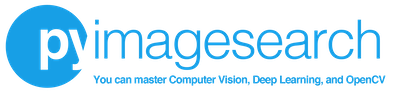

# Adversarial images and attacks with Keras and TensorFlow

### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [Adversarial images and attacks with Keras and TensorFlow](https://www.pyimagesearch.com/2020/10/19/adversarial-images-and-attacks-with-keras-and-tensorflow/) blog post published on 10-19-20.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2020 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch Plus at [http://pyimg.co/plus/](http://pyimg.co/plus) today.*

### Download the code zip file



In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/basic-image-adversaries/basic-image-adversaries.zip
!unzip -qq basic-image-adversaries.zip
%cd basic-image-adversaries

--2023-05-13 01:11:48--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/basic-image-adversaries/basic-image-adversaries.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.181.25, 52.218.132.169, 52.218.182.25, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.181.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170863 (167K) [binary/octet-stream]
Saving to: ‘basic-image-adversaries.zip’

basic-image-adversa 100%[===================>] 166.86K   881KB/s    in 0.2s    

2023-05-13 01:11:49 (881 KB/s) - ‘basic-image-adversaries.zip’ saved [170863/170863]

/content/basic-image-adversaries


## Blog Post Code

### Import Packages

In [2]:
# import necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import argparse
import imutils
import json
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Our ImageNet class label/index helper utility

In [4]:
def get_class_idx(label):
	# build the path to the ImageNet class label mappings file
	labelPath = os.path.join("pyimagesearch",
		"imagenet_class_index.json")

	# open the ImageNet class mappings file and load the mappings as
	# a dictionary with the human-readable class label as the key and
	# the integer index as the value
	with open(labelPath) as f:
		imageNetClasses = {labels[1]: int(idx) for (idx, labels) in
			json.load(f).items()}

	# check to see if the input class label has a corresponding
	# integer index value, and if so return it; otherwise return
	# a None-type value
	return imageNetClasses.get(label, None)

### Normal image classification without adversarial attacks using Keras and TensorFlow

In [5]:
def preprocess_image(image):
	# swap color channels, preprocess the image, and add in a batch
	# dimension
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = preprocess_input(image)
	image = cv2.resize(image, (224, 224))
	image = np.expand_dims(image, axis=0)

	# return the preprocessed image
	return image

In [6]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "pig.jpg"
}

In [7]:
# load image from disk and make a clone for annotation
print("[INFO] loading image...")
image = cv2.imread(args["image"])
output = image.copy()

# preprocess the input image
output = imutils.resize(output, width=400)
preprocessedImage = preprocess_image(image)

[INFO] loading image...


In [8]:
# load the pre-trained ResNet50 model
print("[INFO] loading pre-trained ResNet50 model...")
model = ResNet50(weights="imagenet")

# make predictions on the input image and parse the top-3 predictions
print("[INFO] making predictions...")
predictions = model.predict(preprocessedImage)
predictions = decode_predictions(predictions, top=3)[0]

[INFO] loading pre-trained ResNet50 model...
102967424/102967424 [==============================] - 1s 0us/step
[INFO] making predictions...
35363/35363 [==============================] - 0s 0us/step


In [9]:
# loop over the top three predictions
for (i, (imagenetID, label, prob)) in enumerate(predictions):
	# print the ImageNet class label ID of the top prediction to our
	# terminal (we'll need this label for our next script which will
	# perform the actual adversarial attack)
	if i == 0:
		print("[INFO] {} => {}".format(label, get_class_idx(label)))

	# display the prediction to our screen
	print("[INFO] {}. {}: {:.2f}%".format(i + 1, label, prob * 100))

[INFO] hog => 341
[INFO] 1. hog: 99.97%
[INFO] 2. wild_boar: 0.03%
[INFO] 3. piggy_bank: 0.00%


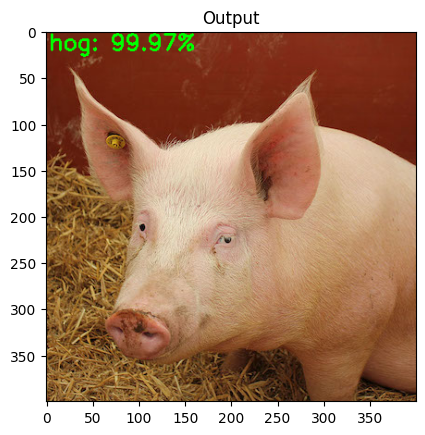

In [10]:
# draw the top-most predicted label on the image along with the
# confidence score
text = "{}: {:.2f}%".format(predictions[0][1],
	predictions[0][2] * 100)
cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8,
	(0, 255, 0), 2)

# show the output image
plt_imshow("Output", output)

### Implementing adversarial images and attacks with Keras and TensorFlow

In [11]:
def preprocess_image(image):
	# swap color channels, resize the input image, and add a batch
	# dimension
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	image = np.expand_dims(image, axis=0)

	# return the preprocessed image
	return image

In [12]:
def clip_eps(tensor, eps):
	# clip the values of the tensor to a given range and return it
	return tf.clip_by_value(tensor, clip_value_min=-eps,
		clip_value_max=eps)

In [13]:
def generate_adversaries(model, baseImage, delta, classIdx, steps=50):
	# iterate over the number of steps
	for step in range(0, steps):
		# record our gradients
		with tf.GradientTape() as tape:
			# explicitly indicate that our perturbation vector should
			# be tracked for gradient updates
			tape.watch(delta)

			# add our perturbation vector to the base image and
			# preprocess the resulting image
			adversary = preprocess_input(baseImage + delta)

			# run this newly constructed image tensor through our
			# model and calculate the loss with respect to the
			# *original* class index
			predictions = model(adversary, training=False)
			loss = -sccLoss(tf.convert_to_tensor([classIdx]),
				predictions)

			# check to see if we are logging the loss value, and if
			# so, display it to our terminal
			if step % 5 == 0:
				print("step: {}, loss: {}...".format(step,
					loss.numpy()))

		# calculate the gradients of loss with respect to the
		# perturbation vector
		gradients = tape.gradient(loss, delta)

		# update the weights, clip the perturbation vector, and
		# update its value
		optimizer.apply_gradients([(gradients, delta)])
		delta.assign_add(clip_eps(delta, eps=EPS))

	# return the perturbation vector
	return delta

In [14]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to original input image")
# ap.add_argument("-o", "--output", required=True,
# 	help="path to output adversarial image")
# ap.add_argument("-c", "--class-idx", type=int, required=True,
# 	help="ImageNet class ID of the predicted label")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"input": "pig.jpg",
    "output": "adversarial.png",
    "class_idx": 341
}

In [15]:
# define the epsilon and learning rate constants
EPS = 2 / 255.0
LR = 0.1

In [16]:
# load the input image from disk and preprocess it
print("[INFO] loading image...")
image = cv2.imread(args["input"])
image = preprocess_image(image)

[INFO] loading image...


In [17]:
# load the pre-trained ResNet50 model for running inference
print("[INFO] loading pre-trained ResNet50 model...")
model = ResNet50(weights="imagenet")

# initialize optimizer and loss function
optimizer = Adam(learning_rate=LR)
sccLoss = SparseCategoricalCrossentropy()

[INFO] loading pre-trained ResNet50 model...


In [18]:
# create a tensor based off of the input image and initialize the
# perturbation vector (we will update this vector via training)
baseImage = tf.constant(image, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)

# generate the perturbation vector to create an adversarial example
print("[INFO] generating perturbation...")
deltaUpdated = generate_adversaries(model, baseImage, delta,
	args["class_idx"])

# create the adversarial example, swap color channels, and save the
# output image to disk
print("[INFO] creating adversarial example...")
adverImage = (baseImage + deltaUpdated).numpy().squeeze()
adverImage = np.clip(adverImage, 0, 255).astype("uint8")
adverImage = cv2.cvtColor(adverImage, cv2.COLOR_RGB2BGR)
cv2.imwrite(args["output"], adverImage)

[INFO] generating perturbation...
step: 0, loss: -0.00031132620642893016...
step: 5, loss: -0.0009654866298660636...
step: 10, loss: -0.005240868777036667...
step: 15, loss: -0.06332480907440186...
step: 20, loss: -0.7731860876083374...
step: 25, loss: -3.456451654434204...
step: 30, loss: -7.4697160720825195...
step: 35, loss: -13.370881080627441...
step: 40, loss: -21.85376739501953...
step: 45, loss: -30.900732040405273...
[INFO] creating adversarial example...


True

[INFO] running inference on the adversarial example...
1/1 [==============================] - 1s 862ms/step
[INFO] label: wombat confidence: 100.00%


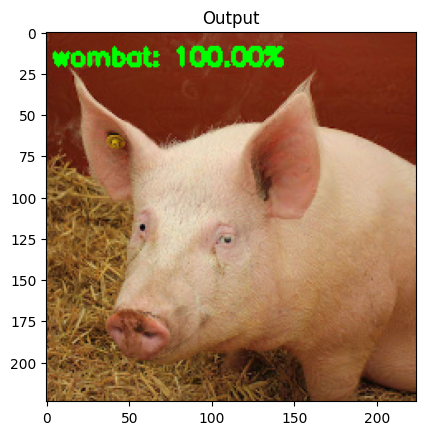

In [19]:
# run inference with this adversarial example, parse the results,
# and display the top-1 predicted result
print("[INFO] running inference on the adversarial example...")
preprocessedImage = preprocess_input(baseImage + deltaUpdated)
predictions = model.predict(preprocessedImage)
predictions = decode_predictions(predictions, top=3)[0]
label = predictions[0][1]
confidence = predictions[0][2] * 100
print("[INFO] label: {} confidence: {:.2f}%".format(label,
	confidence))

# draw the top-most predicted label on the adversarial image along
# with the confidence score
text = "{}: {:.2f}%".format(label, confidence)
cv2.putText(adverImage, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
	(0, 255, 0), 2)

# show the output image
plt_imshow("Output", adverImage)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Adversarial images and attacks with Keras and TensorFlow*](https://www.pyimagesearch.com/2020/10/19/adversarial-images-and-attacks-with-keras-and-tensorflow/) blog post published on 10-19-20.

# Code License Agreement
```
Copyright (c) 2020 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```